In [27]:
using StateSpaceDynamics, Plots


In [28]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [29]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.00918994518478555 0.032159415587346474; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863967 -0.10696223889695364], [-0.0037362031674817928 0.011184638740456908 … -0.07094318488635357 -0.050323491624458885; 0.01979088919057409 0.030620168627788776 … 0.030785185388674228 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.137359927485125 0.03213684839745746; 0.042094688716242876 -0.10110240825174423 … -0.06636174473552493 -0.08508079724902803], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

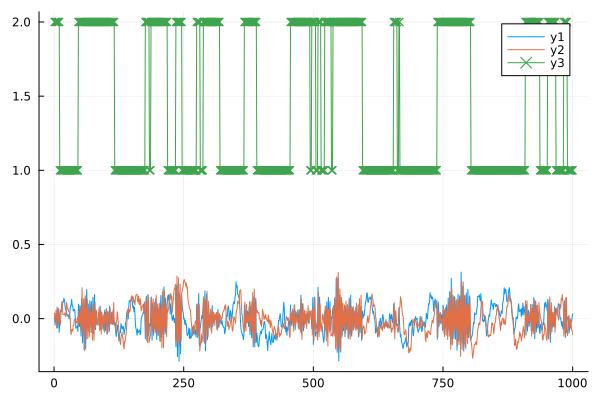

In [30]:
plot(x')
plot!(z, marker=:x)

In [46]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# x0 = model.B[1].state_model.x0
# P0 = model.B[1].state_model.P0

# set up the observation parameters
C = randn(p, d)
R = Matrix(0.5 * I(p))

# C = model.B[1].obs_model.C
#R = model.B[1].obs_model.R

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

# B = [StateSpaceDynamics.LinearDynamicalSystem(
#    StateSpaceDynamics.GaussianStateModel(model.B[i].state_model.A, model.B[i].state_model.Q, x0, P0),
#    StateSpaceDynamics.GaussianObservationModel(C, R),
#    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167399283 0.8337034337958541], [0.5 0.0; 0.0 0.5], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([1.1418730617033803 0.719900722742991; -1.322219379521047 -0.8972060302392916; … ; -0.5604524315368405 -0.7175734441134348; 0.05903811083271828 -0.126827044108007], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.455454261673992

In [47]:
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T_step)
FS = [StateSpaceDynamics.initialize_FilterSmooth(modeli.B[k], T_step) for k in 1:K]
StateSpaceDynamics.variational_qs!([model.obs_model for model in modeli.B], FB, y, FS)
StateSpaceDynamics.forward!(modeli, FB)
StateSpaceDynamics.backward!(modeli, FB)
StateSpaceDynamics.calculate_γ!(modeli, FB) 

In [48]:
FB.loglikelihoods

2×1000 Matrix{Float64}:
 -0.0189894  -0.0502268  -0.0143499  …  -0.0299438  -0.0618135  -0.081465
 -0.0189894  -0.0502268  -0.0143499     -0.0299438  -0.0618135  -0.081465

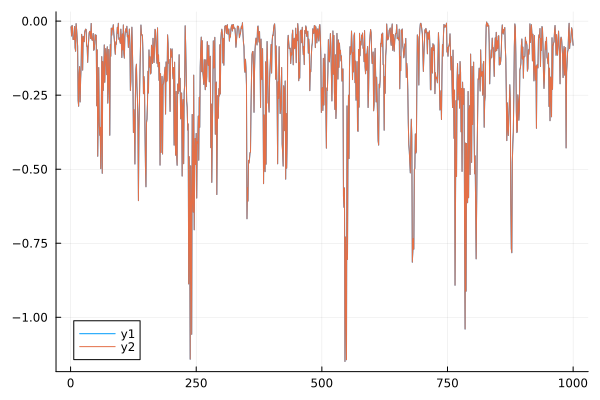

In [49]:
plot(FB.loglikelihoods')

In [6]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [7]:
modeli.A

2×2 Matrix{Float64}:
 0.9  0.1
 0.2  0.8

In [8]:
K = modeli.K
T_step = size(y, 2)
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T_step)
FS = [StateSpaceDynamics.initialize_FilterSmooth(modeli.B[k], T_step) for k in 1:K]
ml = zeros(10)

for i in 1:length(ml)
    ml[i] = variational_expectation!(modeli, y, FB, FS)   
end

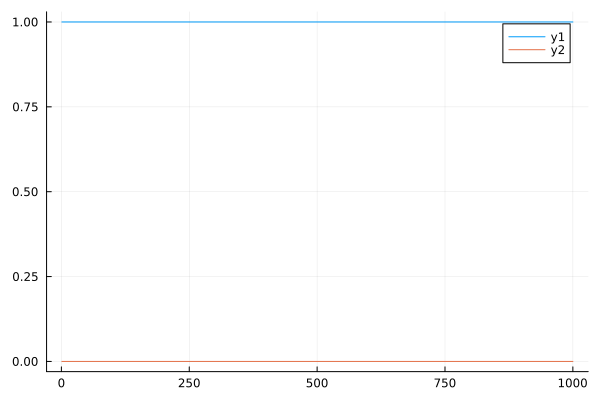

In [11]:
plot(exp.(FB.γ[1,:]))
plot!(exp.(FB.γ[2,:]))

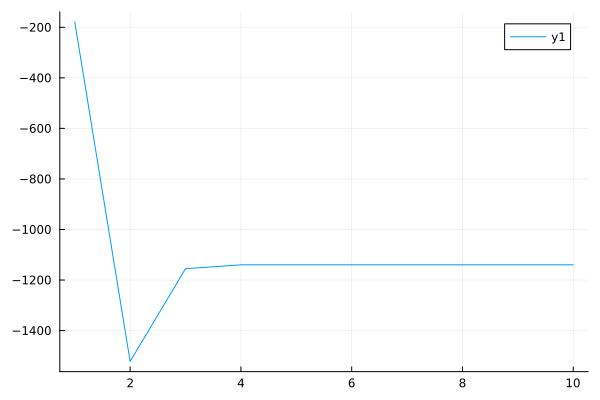

In [12]:
plot(ml)

In [13]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=10)

Fitting SLDS via vEM... 100%|██████████████████████████████████████████████████| Time: 0:00:10 ( 1.09  s/it)


([-1140.0329384080624, -183.63378181041827, -179.26832223563773, -178.98721646303935, -178.96634203473846, -178.9647701501186, -178.96465163275727, -178.96464269564567, -178.964642021706, -178.96464197088494], [8.399635302832705, 0.42691230392785934, 0.10775905393191065, 0.029325380715595553, 0.008043487106337148, 0.0022080599867663844, 0.0006062188200299276, 0.00016644122651996297, 4.5698136013416786e-5, 1.2547015473238127e-5], StateSpaceDynamics.ForwardBackward{Float64}([-0.018989448029639835 -0.05022677598650758 … -0.06181347956610603 -0.08146502295048814; -0.018989448021516236 -0.05022677597870891 … -0.061813479558087976 -0.08146502294193687], [-0.018989449405648475 -0.06921622401613939 … -178.88317694793446 -178.96464197088494; -20.423062434419037 -43.579378034442065 … -222.39338843737826 -222.4748534603282], [-178.94565252285497 -178.89542574686845 … -0.08146502295048814 0.0; -178.94565252285497 -178.89542574686845 … -0.08146502295048356 0.0], [-1.3760086403635796e-9 0.0 … 0.0 0.

In [14]:
param_diff

10-element Vector{Float64}:
 8.399635302832705
 0.42691230392785934
 0.10775905393191065
 0.029325380715595553
 0.008043487106337148
 0.0022080599867663844
 0.0006062188200299276
 0.00016644122651996297
 4.5698136013416786e-5
 1.2547015473238127e-5

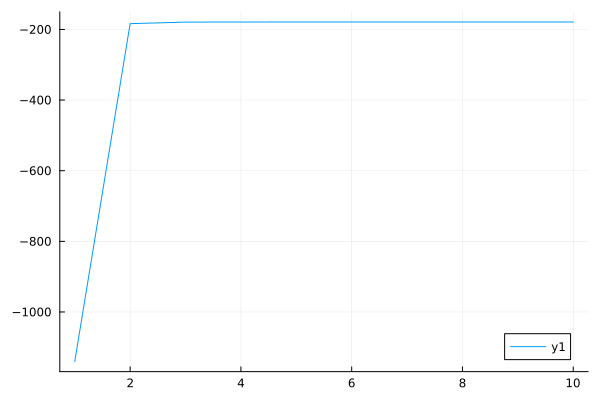

In [15]:
plot(mls)

In [16]:
diff(mls)

9-element Vector{Float64}:
 956.3991565976442
   4.3654595747805445
   0.2811057725983801
   0.020874428300885484
   0.0015718846198637948
   0.0001185173613293955
   8.937111601881043e-6
   6.739396667398978e-7
   5.082105758447142e-8

In [17]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [18]:
modeli.A

2×2 Matrix{Float64}:
 1.0  1.26986e-19
 1.0  4.58487e-15

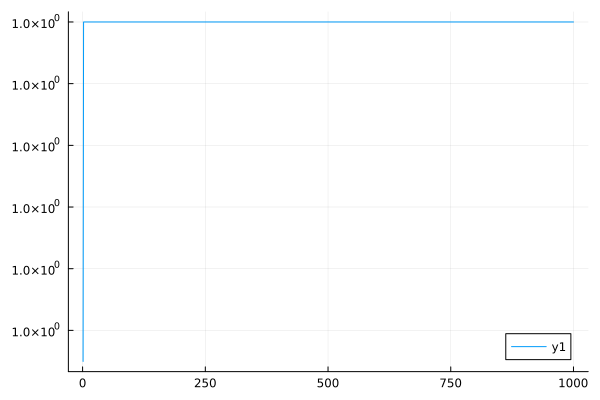

In [19]:
plot(exp.(FB.γ[1,:]))
#plot!(exp.(FB.γ[2,:]))

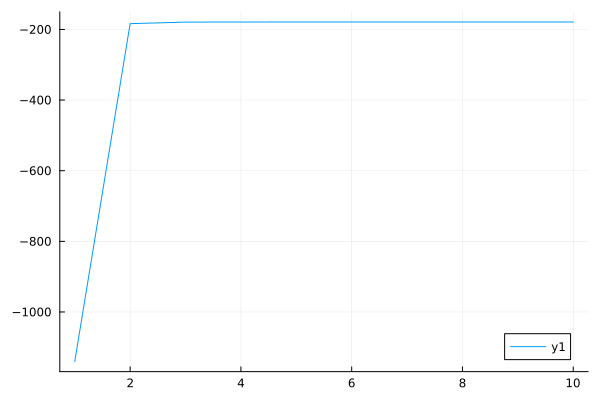

In [20]:
plot(mls)

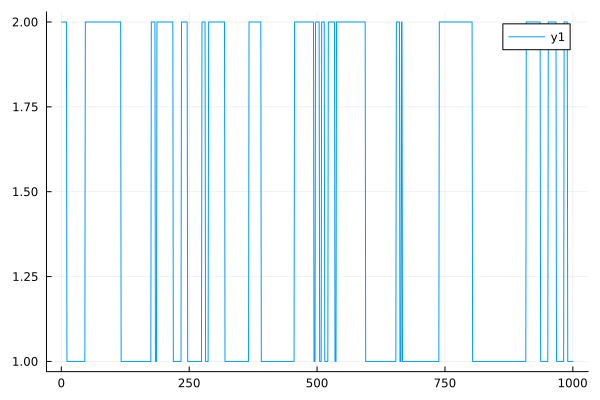

In [21]:
plot(z)

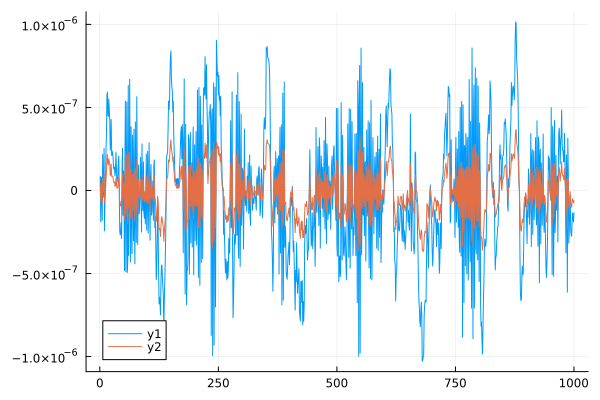

In [22]:
plot(FS[1].x_smooth')

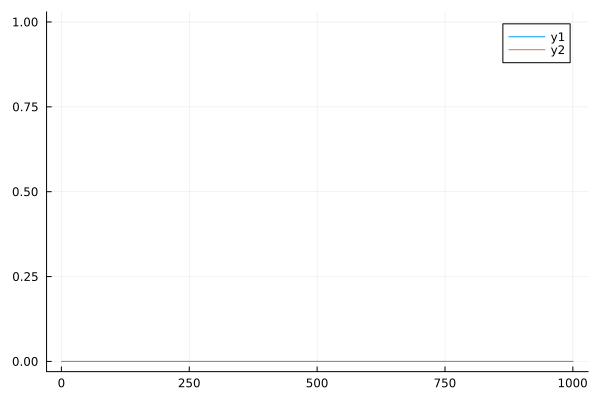

In [23]:
plot(FS[2].x_smooth')


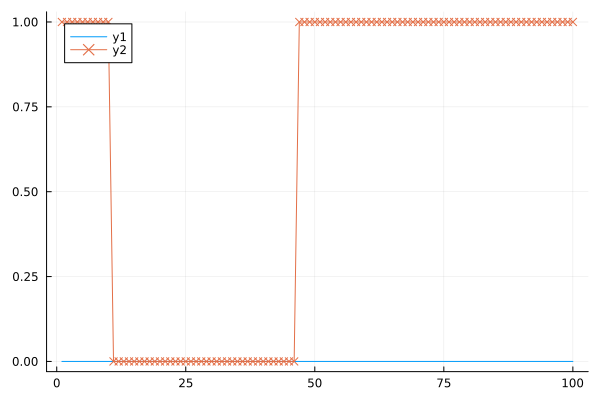

In [24]:
plot(exp.(FB.γ)'[1:100,2])
plot!(z[1:100] .- 1, marker=:x)

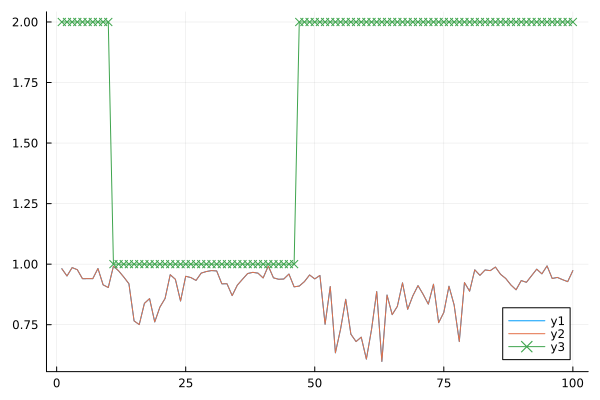

In [25]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

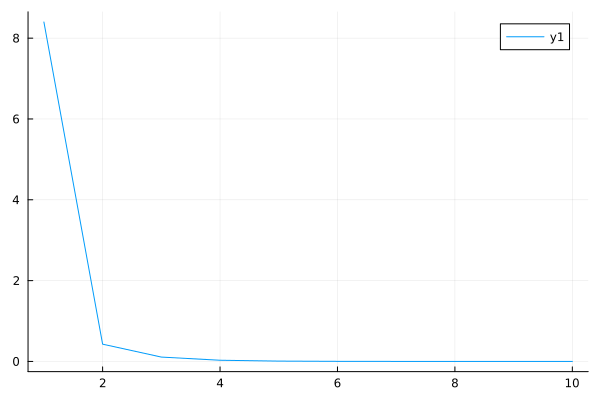

In [26]:
plot(param_diff)